## Imports

In [9]:
import numpy as np
import pandas as pd
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from preprocess.preprocess import Preprocess
from regression_tree.regression_tree import MyDecisionTreeRegressor
from random_forest.random_forest import MyRandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import copy
from sklearn.base import clone
import importlib
import eval.eval as eval_mod

importlib.reload(eval_mod)
from eval.eval import plot_used_cars_results

sns.set_theme(style="whitegrid")

## Preprocessing

In [10]:
pp = Preprocess('insurance.csv', 'charges', scale=True)
results_df = pd.DataFrame(
)

## Data splitting

In [11]:
X_train, X_test, y_train, y_test = pp.preprocess_data()

## Define configs, Hold-out accuracy

In [ ]:
experiment_configs = [
    {
        "name": "Linear Regression",
        "model": Ridge(),
        "params": {} 
    },
    {
        "name": "Decision Tree",
        "model": DecisionTreeRegressor(random_state=42),
        "params": {"random_state": 42}
    },
    {
        "name": "Random Forest (10 Trees)",
        "model": RandomForestRegressor(random_state=42),
        "params": {"random_state": 42}
    },
    {
        "name": "MyDecisionTreeRegressor post-pruned",
        "model": MyDecisionTreeRegressor(max_depth=20, min_samples=20),
        "params": {"pruned": True, "max_depth": 20, "min_samples": 20}
    },
    {
        "name": "MyDecisionTreeRegressor without post-pruning",
        "model": MyDecisionTreeRegressor(max_depth=20, min_samples=20),
        "params": {"pruned": False, "max_depth": 20, "min_samples": 20}
    },
    {
        "name": "MyRandomForestRegressor 100 trees, with all features",
        "model": MyRandomForestRegressor(max_depth=20, min_samples=20, n_estimators=100, max_features=None),
        "params": {"max_depth":20, "min_samples":20, "n_estimators":100, "max_features":None}
    },
    {
        "name": "MyRandomForestRegressor 100 trees, 0.5 max features",
        "model": MyRandomForestRegressor(max_depth=20, min_samples=20, n_estimators=100, max_features=0.5),
        "params": {"max_depth":20, "min_samples":20, "n_estimators":100, "max_features":0.5}
    },
    {
        "name": "MyRandomForestRegressor 500 trees, with all features",
        "model": MyRandomForestRegressor(max_depth=20, min_samples=20, n_estimators=500, max_features=None),
        "params": {"max_depth":20, "min_samples":20, "n_estimators":500, "max_features":None}
    },
    
]

models_store = {}
preds_test = {}

results = []

# Loop for models
for config in experiment_configs:
    model = config["model"]
    name = config["name"]
    params = config["params"]
    
    model.fit(X_train, y_train)

    # post prune for custom tree 
    if "MyDecisionTreeRegressor" in name and params.get("pruned"):
        model.post_prune_with_cross_validation(X_train, y_train, n_splits=10)

    # predict
    y_pred = model.predict(X_test)

    # evaluate
    r2 = float(r2_score(y_test, y_pred))
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))

    # store for later plotting
    models_store[name] = model
    preds_test[name] = y_pred

    results.append({"model_name": name, "rsquared": r2, "rmse": rmse, "params": params})

results_df = pd.DataFrame(results).sort_values(["rmse"], ascending=True).reset_index(drop=True)
results_df[["model_name", "rsquared", "rmse", "params"]]

,model_name,rsquared,rmse,params
0,"MyRandomForestRegressor 500 trees, with all fe...",0.858404,4419.720793,"{'max_depth': 20, 'min_samples': 20, 'n_estima..."
1,"MyRandomForestRegressor 100 trees, with all fe...",0.855546,4464.102167,"{'max_depth': 20, 'min_samples': 10, 'n_estima..."
2,MyDecisionTreeRegressor post-pruned,0.855029,4472.077509,"{'pruned': True, 'max_depth': 20, 'min_samples..."
3,Random Forest (10 Trees),0.840832,4685.948660,{'random_state': 42}
4,MyDecisionTreeRegressor without post-pruning,0.817525,5017.302497,"{'pruned': False, 'max_depth': 20, 'min_sample..."
5,Linear Regression,0.766055,5681.018521,{}
6,"MyRandomForestRegressor 100 trees, 0.5 max fea...",0.754739,5816.791093,"{'max_depth': 20, 'min_samples': 20, 'n_estima..."
7,Decision Tree,0.705308,6376.076526,{'random_state': 42}


## 10-fold CV accuracy for models

In [16]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

cv_rows = []

for config in experiment_configs:
    name = config["name"]
    base_model = config["model"]
    params = config["params"]

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train), start=1):
        # Create folds
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        if hasattr(base_model, "get_params"):
            model = clone(base_model)
        else:
            model = copy.deepcopy(base_model)

        model.fit(X_fold_train, y_fold_train)

        # Post-prune for the pruned custom decision tree regressor
        if "MyDecisionTreeRegressor" in name and params.get("pruned"):
            model.post_prune_with_cross_validation(X_fold_train, y_fold_train, n_splits=10)

        y_pred = model.predict(X_fold_val)

        cv_rows.append(
            {
                "model_name": name,
                "fold": fold_idx,
                "r2": float(r2_score(y_fold_val, y_pred)),
                "rmse": float(np.sqrt(mean_squared_error(y_fold_val, y_pred))),
            }
        )

cv_long_df = pd.DataFrame(cv_rows)

df_results = (
    cv_long_df.groupby("model_name")
    .agg(mean_r2=("r2", "mean"), std_r2=("r2", "std"), mean_rmse=("rmse", "mean"), std_rmse=("rmse", "std"))
    .reset_index()
    .sort_values(["mean_rmse"], ascending=True)
)

df_results

,model_name,mean_r2,std_r2,mean_rmse,std_rmse
6,"MyRandomForestRegressor 500 trees, with all fe...",0.848571,0.050222,4599.372938,774.833376
5,"MyRandomForestRegressor 100 trees, with all fe...",0.847851,0.049646,4612.562831,771.016154
2,MyDecisionTreeRegressor post-pruned,0.843057,0.046939,4702.898947,770.914031
7,Random Forest (10 Trees),0.837760,0.052233,4759.454912,778.962875
3,MyDecisionTreeRegressor without post-pruning,0.817680,0.070707,5031.518694,986.174628
1,Linear Regression,0.739485,0.044862,6093.676716,668.398339
4,"MyRandomForestRegressor 100 trees, 0.5 max fea...",0.723724,0.044481,6281.004748,708.373297
0,Decision Tree,0.682949,0.088806,6659.504819,872.916861


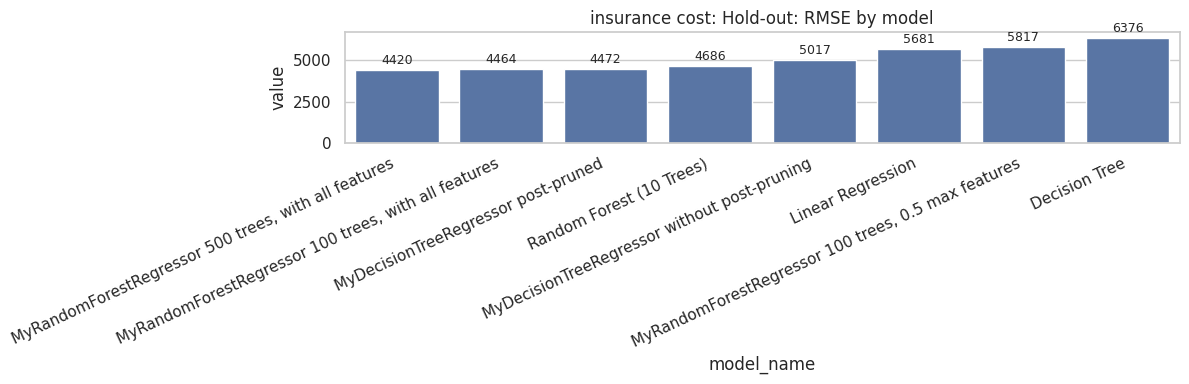

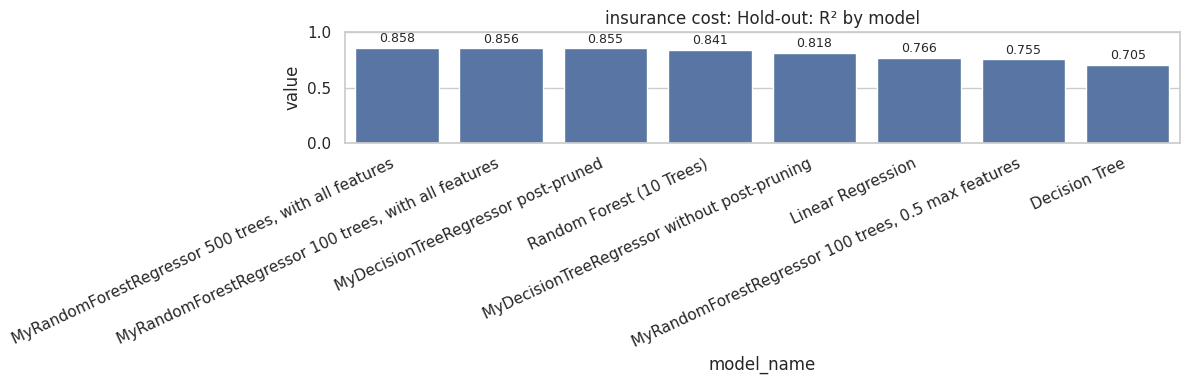

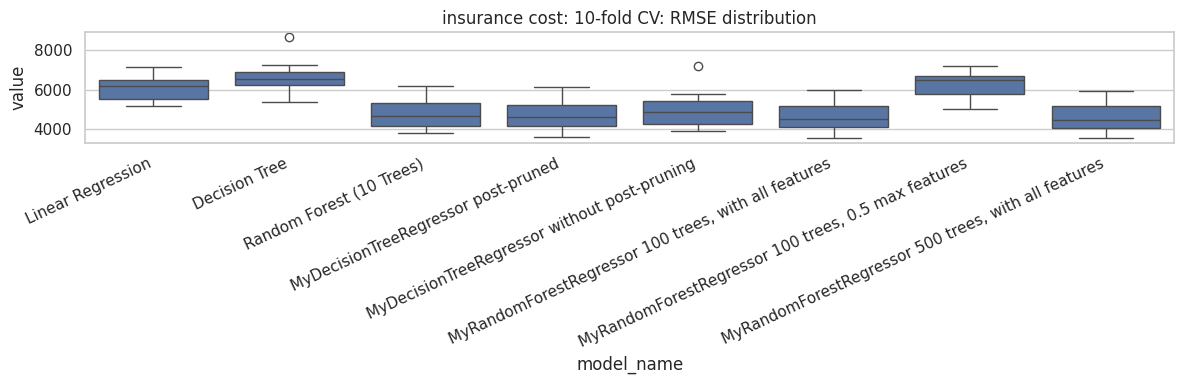

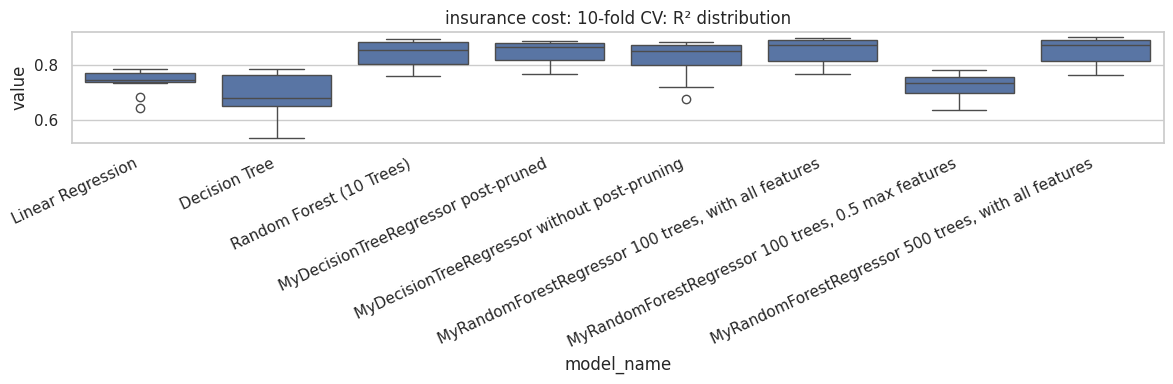

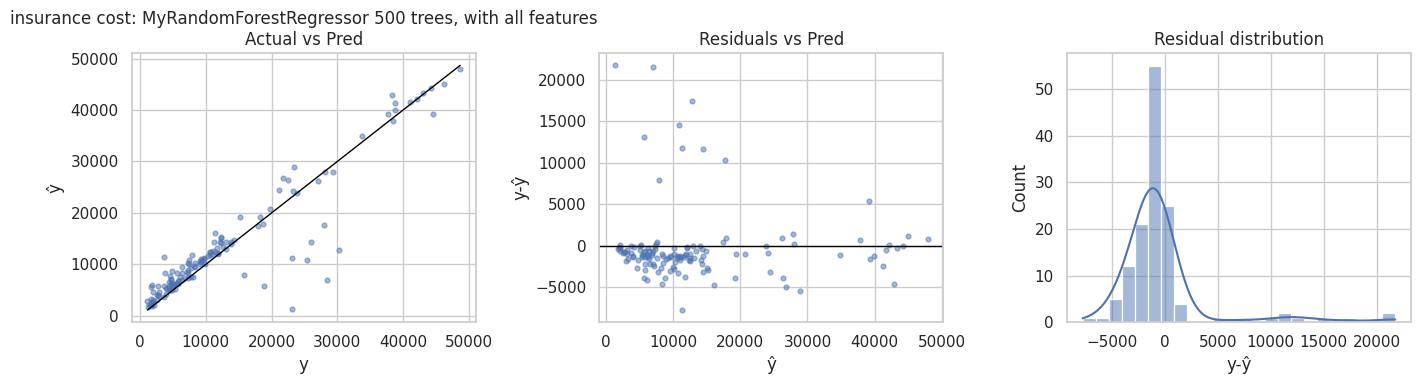

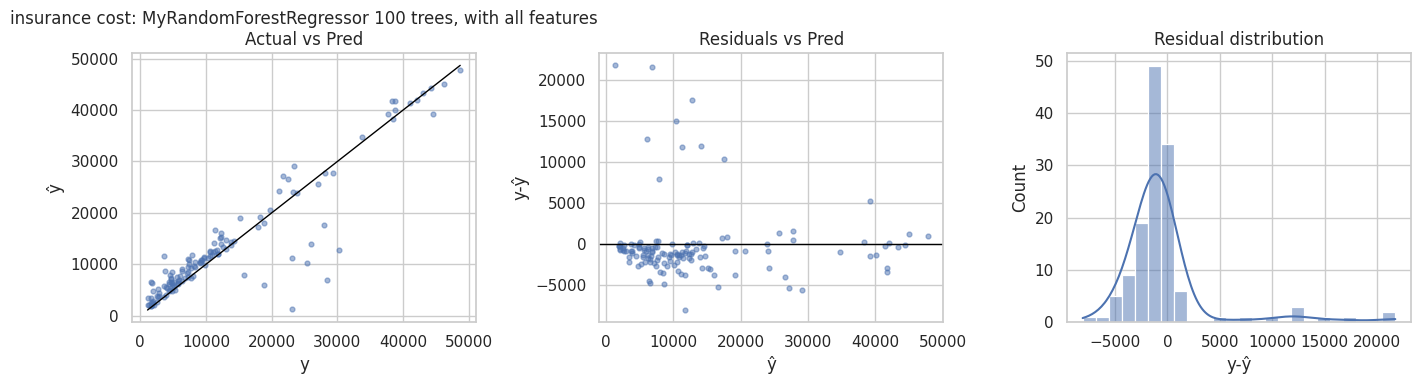

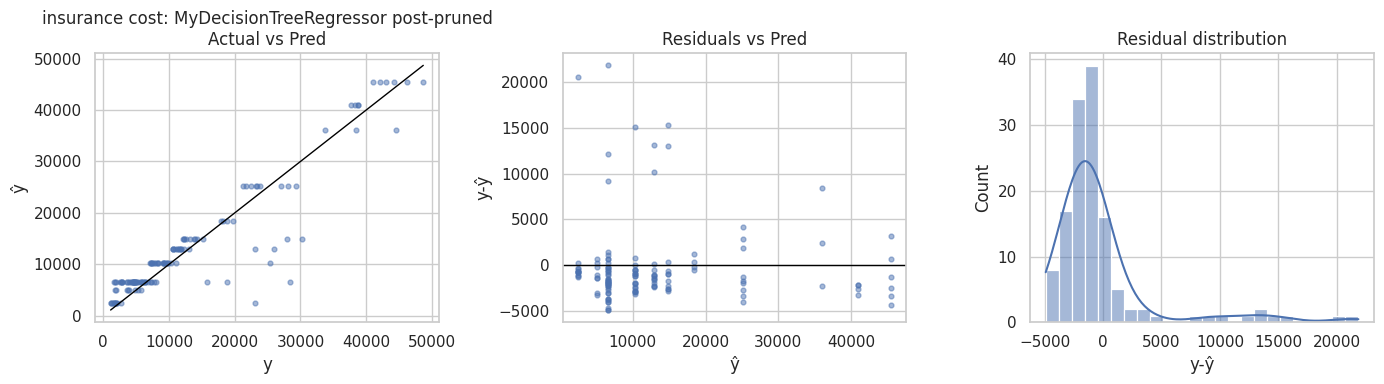

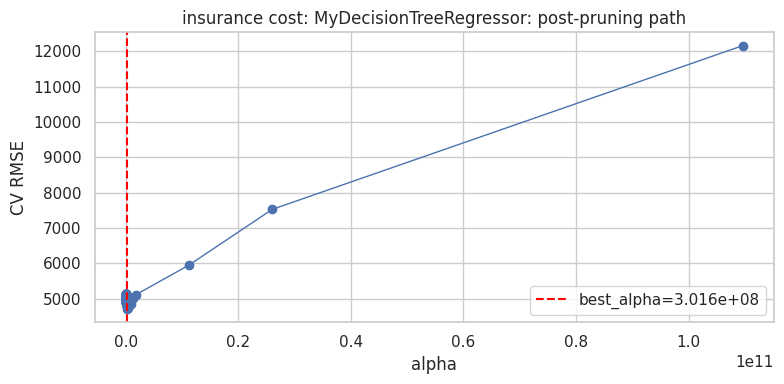

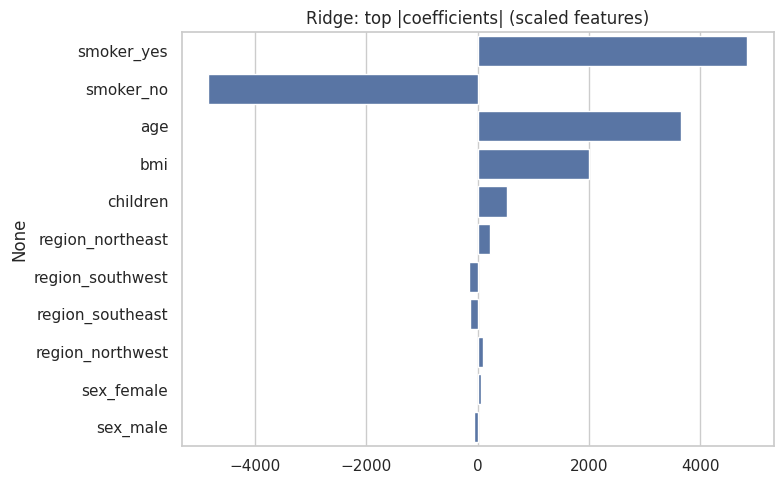

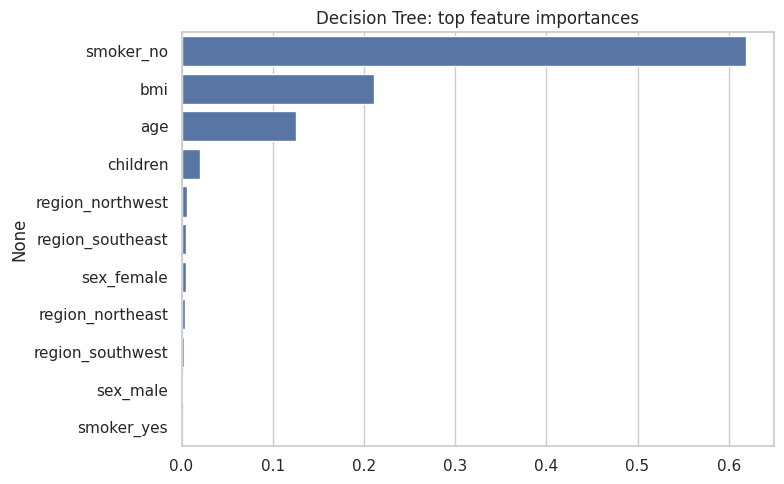

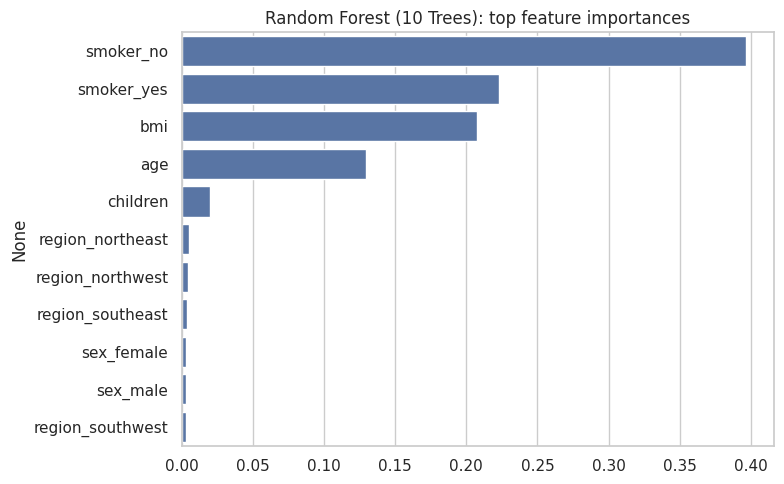

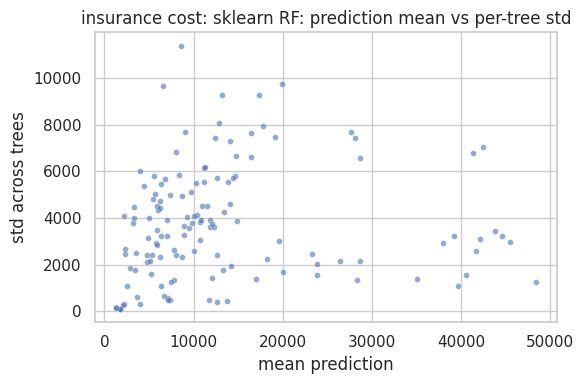

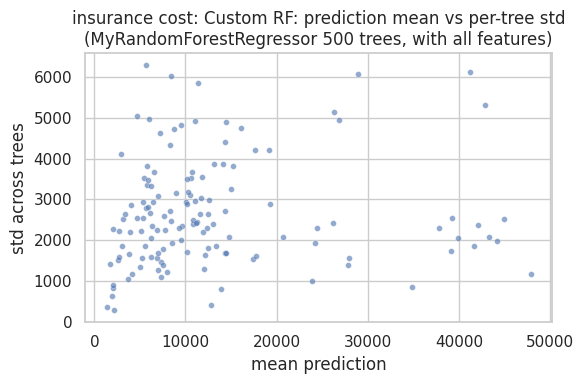

In [17]:

plot_used_cars_results(
    dataset_name="insurance cost",
    results_df=results_df,
    df_results=df_results,
    cv_long_df=cv_long_df,
    y_test=y_test,
    preds_test=preds_test,
    models_store=models_store,
    X_test=X_test,
    feature_names=getattr(pp, "feature_names_", None),
)
